## Create London per-day dataset

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import pydotplus
from ipywidgets import *
from IPython.display import display
from IPython.display import Image
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 14
import pgeocode

plt.style.use("ggplot")
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.stats as stats

# from pygeocoder import Geocoder
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

In [2]:
london_all = pd.read_pickle("../pickled_data/london_counts_df.pickled")
london_f = london_all
london_per_day = london_f.groupby([london_all["timestamp"].dt.date]).mean()
london_per_day["count"] = (
    london_all["cnt"].groupby([london_all["timestamp"].dt.date]).sum()
)
london_per_day.rename(columns={"t1": "temp", "wind_speed": "wind"}, inplace=True)
del london_per_day['cnt']
del london_per_day['is_weekend']
del london_per_day['hum_binary']
del london_per_day['t2']


london_per_day.head()

,temp,hum,wind,weather_code,is_holiday,season,is_workday,count
timestamp,,,,,,,,
2015-01-04,2.479167,94.270833,7.500000,2.875000,0.0,3.0,0.0,9234
2015-01-05,8.041667,80.312500,8.854167,3.333333,0.0,3.0,1.0,20372
2015-01-06,7.854167,78.895833,16.000000,3.083333,0.0,3.0,1.0,20613
2015-01-07,7.456522,78.108696,19.760870,2.608696,0.0,3.0,1.0,21064
2015-01-08,9.750000,79.312500,20.479167,3.500000,0.0,3.0,1.0,15601


In [3]:
london_per_day.corr()

,temp,hum,wind,weather_code,is_holiday,season,is_workday,count
temp,1.000000,-0.370407,0.036309,-0.203173,-0.046082,-0.308772,0.020168,0.677384
hum,-0.370407,1.000000,-0.186382,0.579546,0.048443,0.436028,-0.058466,-0.564006
wind,0.036309,-0.186382,1.000000,0.210156,-0.004301,0.012329,-0.014184,-0.197499
weather_code,-0.203173,0.579546,0.210156,1.000000,0.023940,0.185493,-0.089818,-0.546002
is_holiday,-0.046082,0.048443,-0.004301,0.023940,1.000000,-0.032373,-0.224267,-0.153142
season,-0.308772,0.436028,0.012329,0.185493,-0.032373,1.000000,0.009687,-0.349045
is_workday,0.020168,-0.058466,-0.014184,-0.089818,-0.224267,0.009687,1.000000,0.338728
count,0.677384,-0.564006,-0.197499,-0.546002,-0.153142,-0.349045,0.338728,1.000000


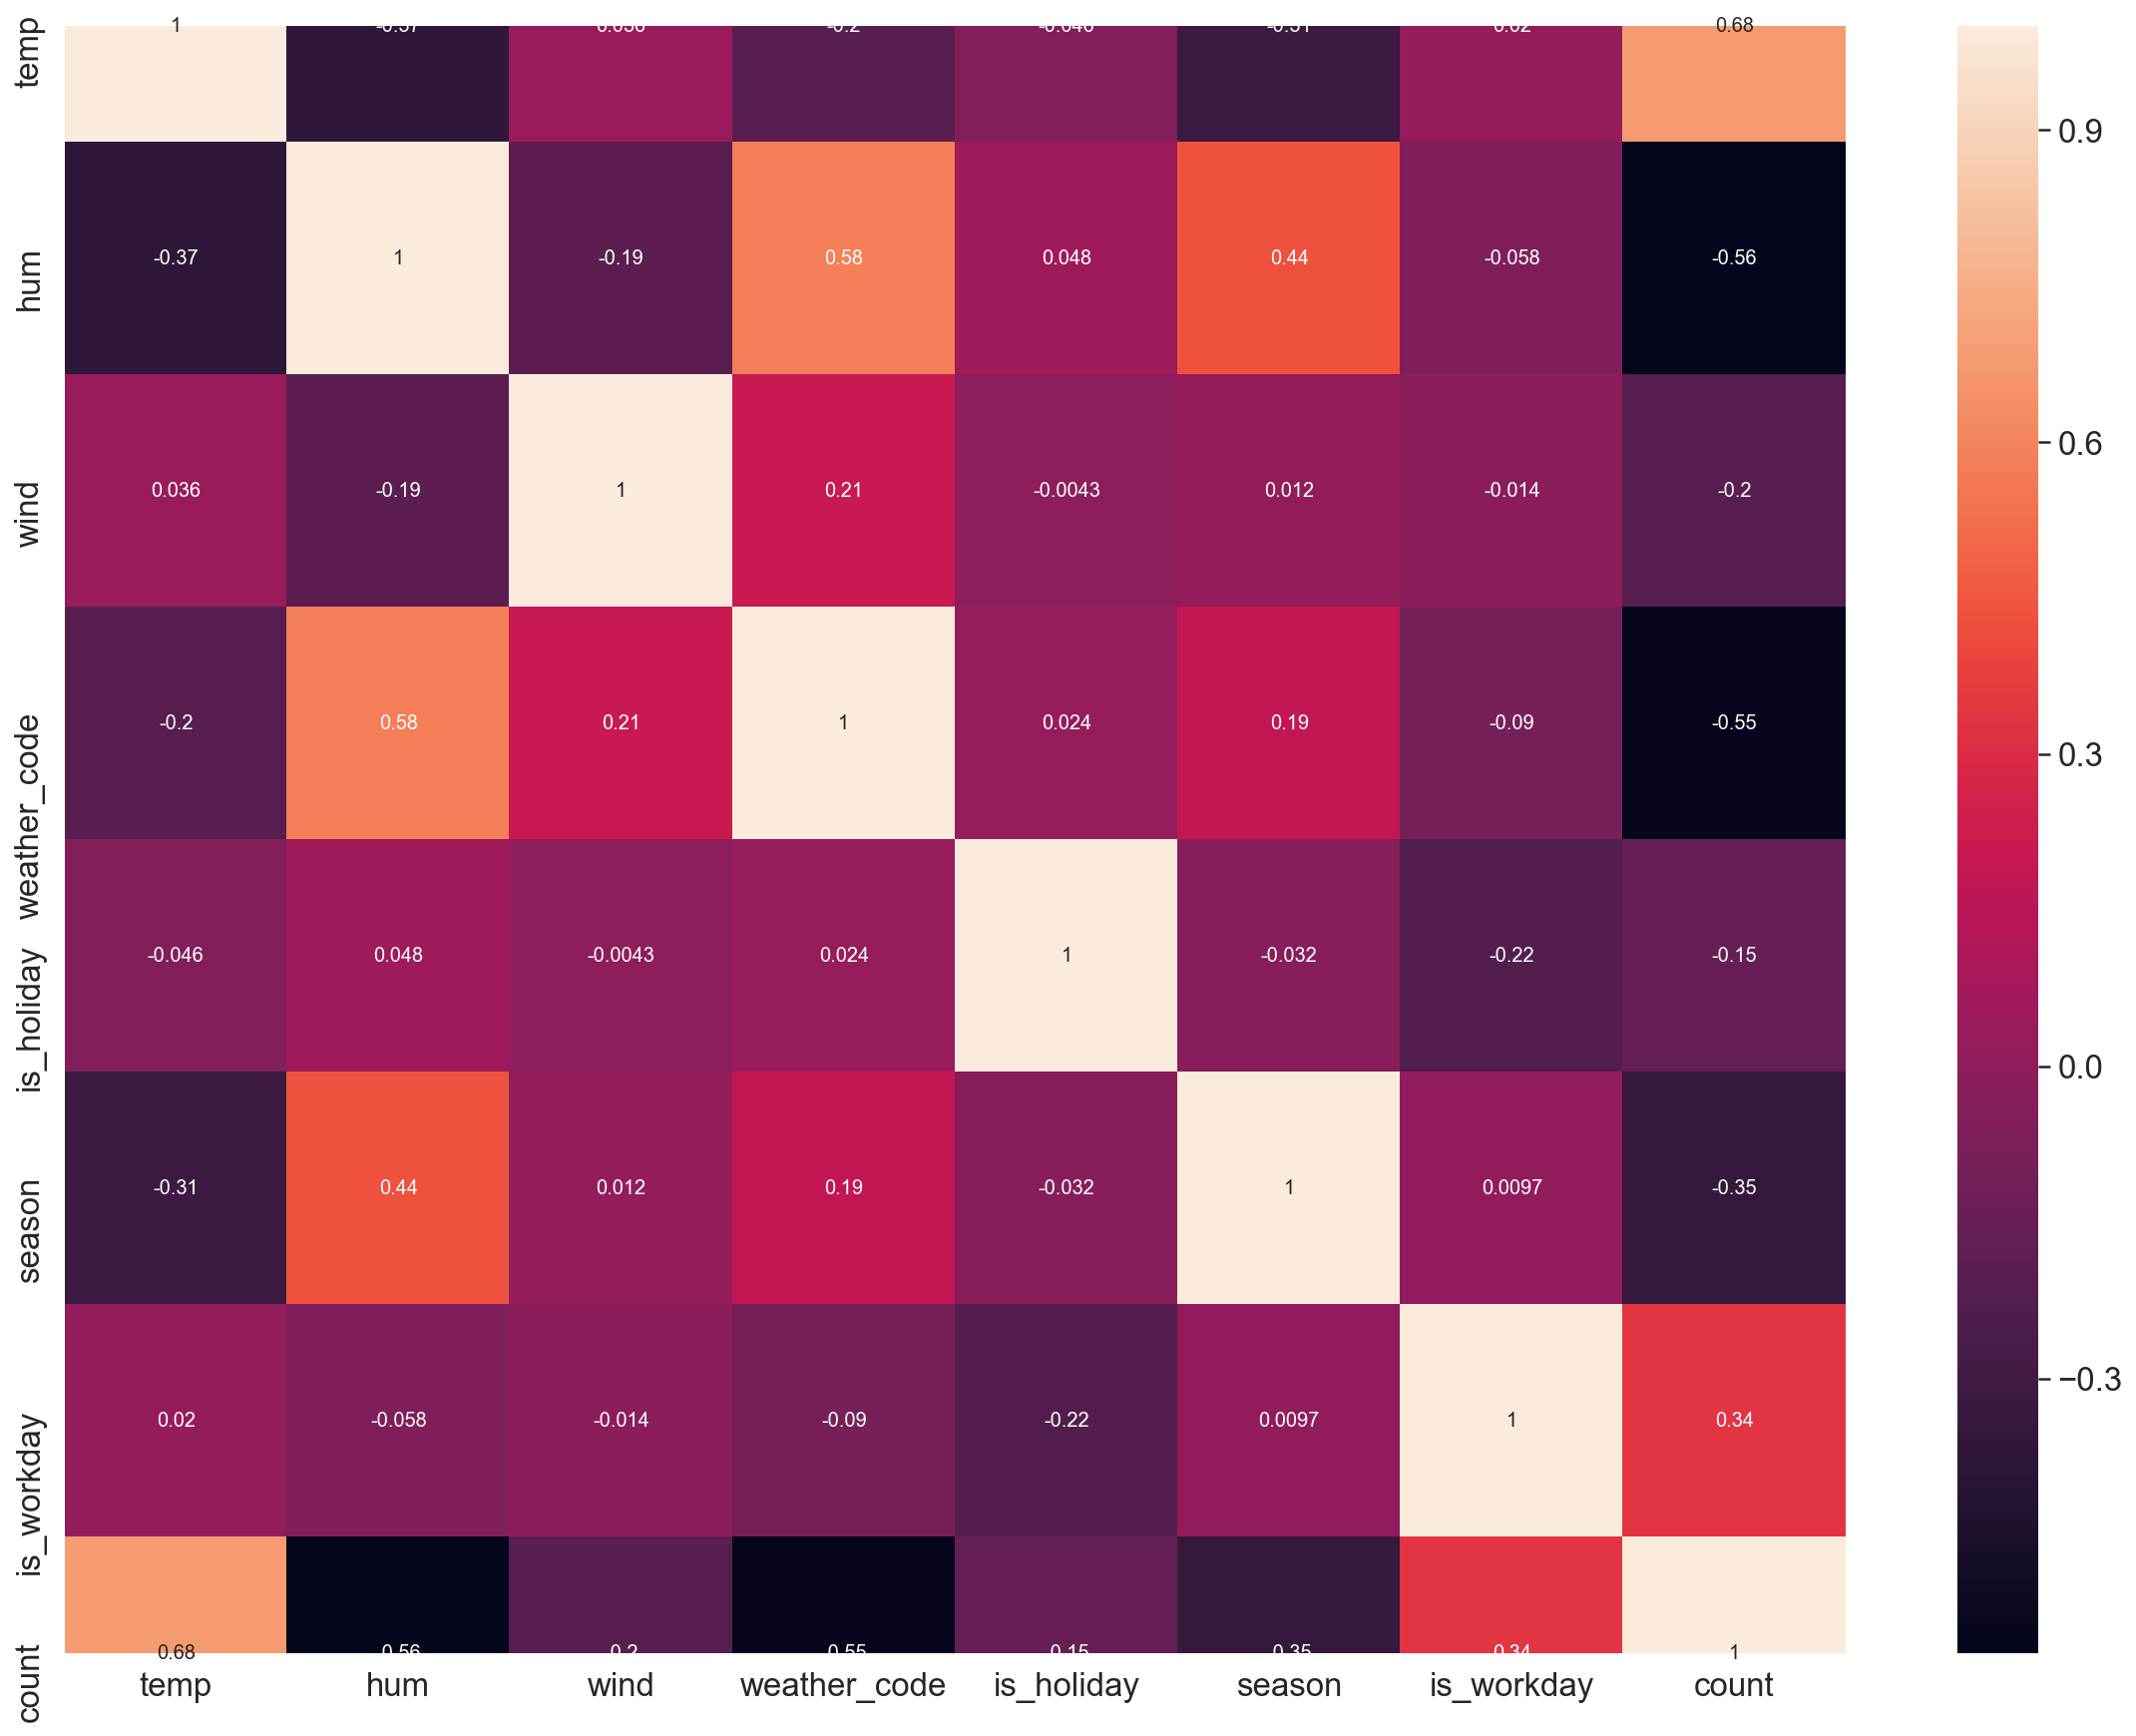

In [4]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(london_per_day.corr(), annot=True, ax=ax)
plt.show()

## Build model

In [5]:
dummied = pd.get_dummies(london_per_day,columns=['is_holiday','is_workday','season'] ,drop_first=True)

In [6]:
dummied.head()

,temp,hum,wind,weather_code,count,is_holiday_1.0,is_workday_1.0,season_1.0,season_2.0,season_3.0
timestamp,,,,,,,,,,
2015-01-04,2.479167,94.270833,7.500000,2.875000,9234,0,0,0,0,1
2015-01-05,8.041667,80.312500,8.854167,3.333333,20372,0,1,0,0,1
2015-01-06,7.854167,78.895833,16.000000,3.083333,20613,0,1,0,0,1
2015-01-07,7.456522,78.108696,19.760870,2.608696,21064,0,1,0,0,1
2015-01-08,9.750000,79.312500,20.479167,3.500000,15601,0,1,0,0,1


In [7]:
# london_per_day_cp = london_per_day.copy()
# y = london_per_day_cp.pop("count")
# X = london_per_day_cp
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X.columns)
# X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X.columns)
dummied_cp = dummied.copy()
y = dummied_cp.pop("count")
X = dummied_cp
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(std_scaler.transform(X_test), columns=X.columns)

/Users/vilvaki/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vilvaki/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/vilvaki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


### Linear Regression

In [8]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

lr.fit(X_train, y_train)
print("Training Score:", lr.score(X_train, y_train))
print("Test Score:", lr.score(X_test, y_test))

Cross-validated training scores: [0.67579879 0.70976824 0.75453697 0.8600423  0.83482894]
Mean cross-validated training score: 0.7669950475147272
Training Score: 0.7741952122885546
Test Score: 0.7923917889941081


### Ridge

In [9]:
# Fit RidgeCV model:
r_cv = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
r_cv.fit(X_train, y_train)
# get the optimal alpha:
print("Best alpha:", r_cv.alpha_)
print("Training score:", r_cv.score(X_train, y_train))
print("Test Score:", r_cv.score(X_test, y_test))
rg = Ridge(alpha=r_cv.alpha_)

scores = cross_val_score(rg, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

rg.fit(X_train, y_train)
print("Training Score:", rg.score(X_train, y_train))
print("Test Score:", rg.score(X_test, y_test))

Best alpha: 2.782559402207126
Training score: 0.7741824042702415
Test Score: 0.7921645353318285
Cross-validated training scores: [0.67601119 0.70986364 0.7544031  0.85988193 0.83519954]
Mean cross-validated training score: 0.7670718784995934
Training Score: 0.7741824042702415
Test Score: 0.7921645353318285


### Lasso

In [10]:
# Fit LassoCV model:
l_cv = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
l_cv.fit(X_train, y_train)
# get the optimal alpha
print("Best alpha:", l_cv.alpha_)
print("Training score:", l_cv.score(X_train, y_train))
print("Test Score:", l_cv.score(X_test, y_test))
lasso = Lasso(alpha=l_cv.alpha_)
scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring="r2")
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

lasso.fit(X_train, y_train)
print("Training Score:", lasso.score(X_train, y_train))
print("Test Score:", lasso.score(X_test, y_test))

df_coef = pd.DataFrame(lasso.coef_, index=X_train.columns, columns=["coefficients"])
df_coef["coef_abs"] = df_coef.coefficients.abs()
df_coef.sort_values(by="coefficients", ascending=False)

Best alpha: 0.0001
Training score: 0.7741952122885537
Test Score: 0.7923917850887056
Cross-validated training scores: [0.67579879 0.70976824 0.75453697 0.8600423  0.83482894]
Mean cross-validated training score: 0.7669950479117181
Training Score: 0.7741952122885537
Test Score: 0.7923917850887056


,coefficients,coef_abs
temp,3840.637141,3840.637141
is_workday_1.0,2264.625144,2264.625144
season_1.0,659.051610,659.051610
season_2.0,400.102123,400.102123
season_3.0,-371.037557,371.037557
is_holiday_1.0,-408.252026,408.252026
wind,-1628.254531,1628.254531
weather_code,-1838.431180,1838.431180
hum,-2252.061440,2252.061440


# regressor

In [11]:
regressor = DecisionTreeRegressor(criterion='mse',
                                  max_depth=None, 
                                  random_state=1)

regressor.fit(X_train, y_train)
print("Train score: ", regressor.score(X_train, y_train))
print("Train CV score: ", cross_val_score(regressor, X_train, y_train, cv=5).mean())
print("Test score: ", regressor.score(X_test, y_test))

Train score:  1.0
Train CV score:  0.5180165163451181
Test score:  0.5540841636336575


In [12]:
gs_params ={
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]
}
lr_gridsearch = GridSearchCV(regressor , gs_params ,return_train_score=True,  cv=10)
lr_gridsearch.fit(X_train, y_train)

/Users/vilvaki/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'max_features': [None, 1, 2, 3], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
pd.DataFrame(lr_gridsearch.cv_results_).head()
print(lr_gridsearch.best_estimator_)
print(lr_gridsearch.best_score_)
print(lr_gridsearch.score(X_test, y_test))

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=3,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=40, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')
0.659807901181489
0.5893883502317592


### Classicfication

In [14]:
mean_count = london_per_day['count'].mean()
list_bin = []
for val in london_per_day['count']:
    if val > mean_count:
        list_bin.append(1)
    else:
        list_bin.append(0)
        
london_per_day['count_class'] = list_bin

In [15]:
# baseline:
london_per_day.count_class.value_counts(normalize=True).max()

0.5095890410958904

In [16]:
london_per_day_cp = london_per_day.copy()
del london_per_day_cp['count']
y = london_per_day_cp.pop("count_class")
X = london_per_day_cp

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    stratify=y, random_state=1)

In [28]:
classifier = DecisionTreeClassifier(criterion='gini',
                                    max_depth=3, 
                                    random_state=1)
classifier.fit(X_train, y_train)
print("Train score: ", classifier.score(X_train, y_train))
print("Train CV score: ", cross_val_score(classifier, X_train, y_train, cv=5).mean())
print("Test score: ", classifier.score(X_test, y_test))

Train score:  0.8681506849315068
Train CV score:  0.8115034942328923
Test score:  0.8287671232876712


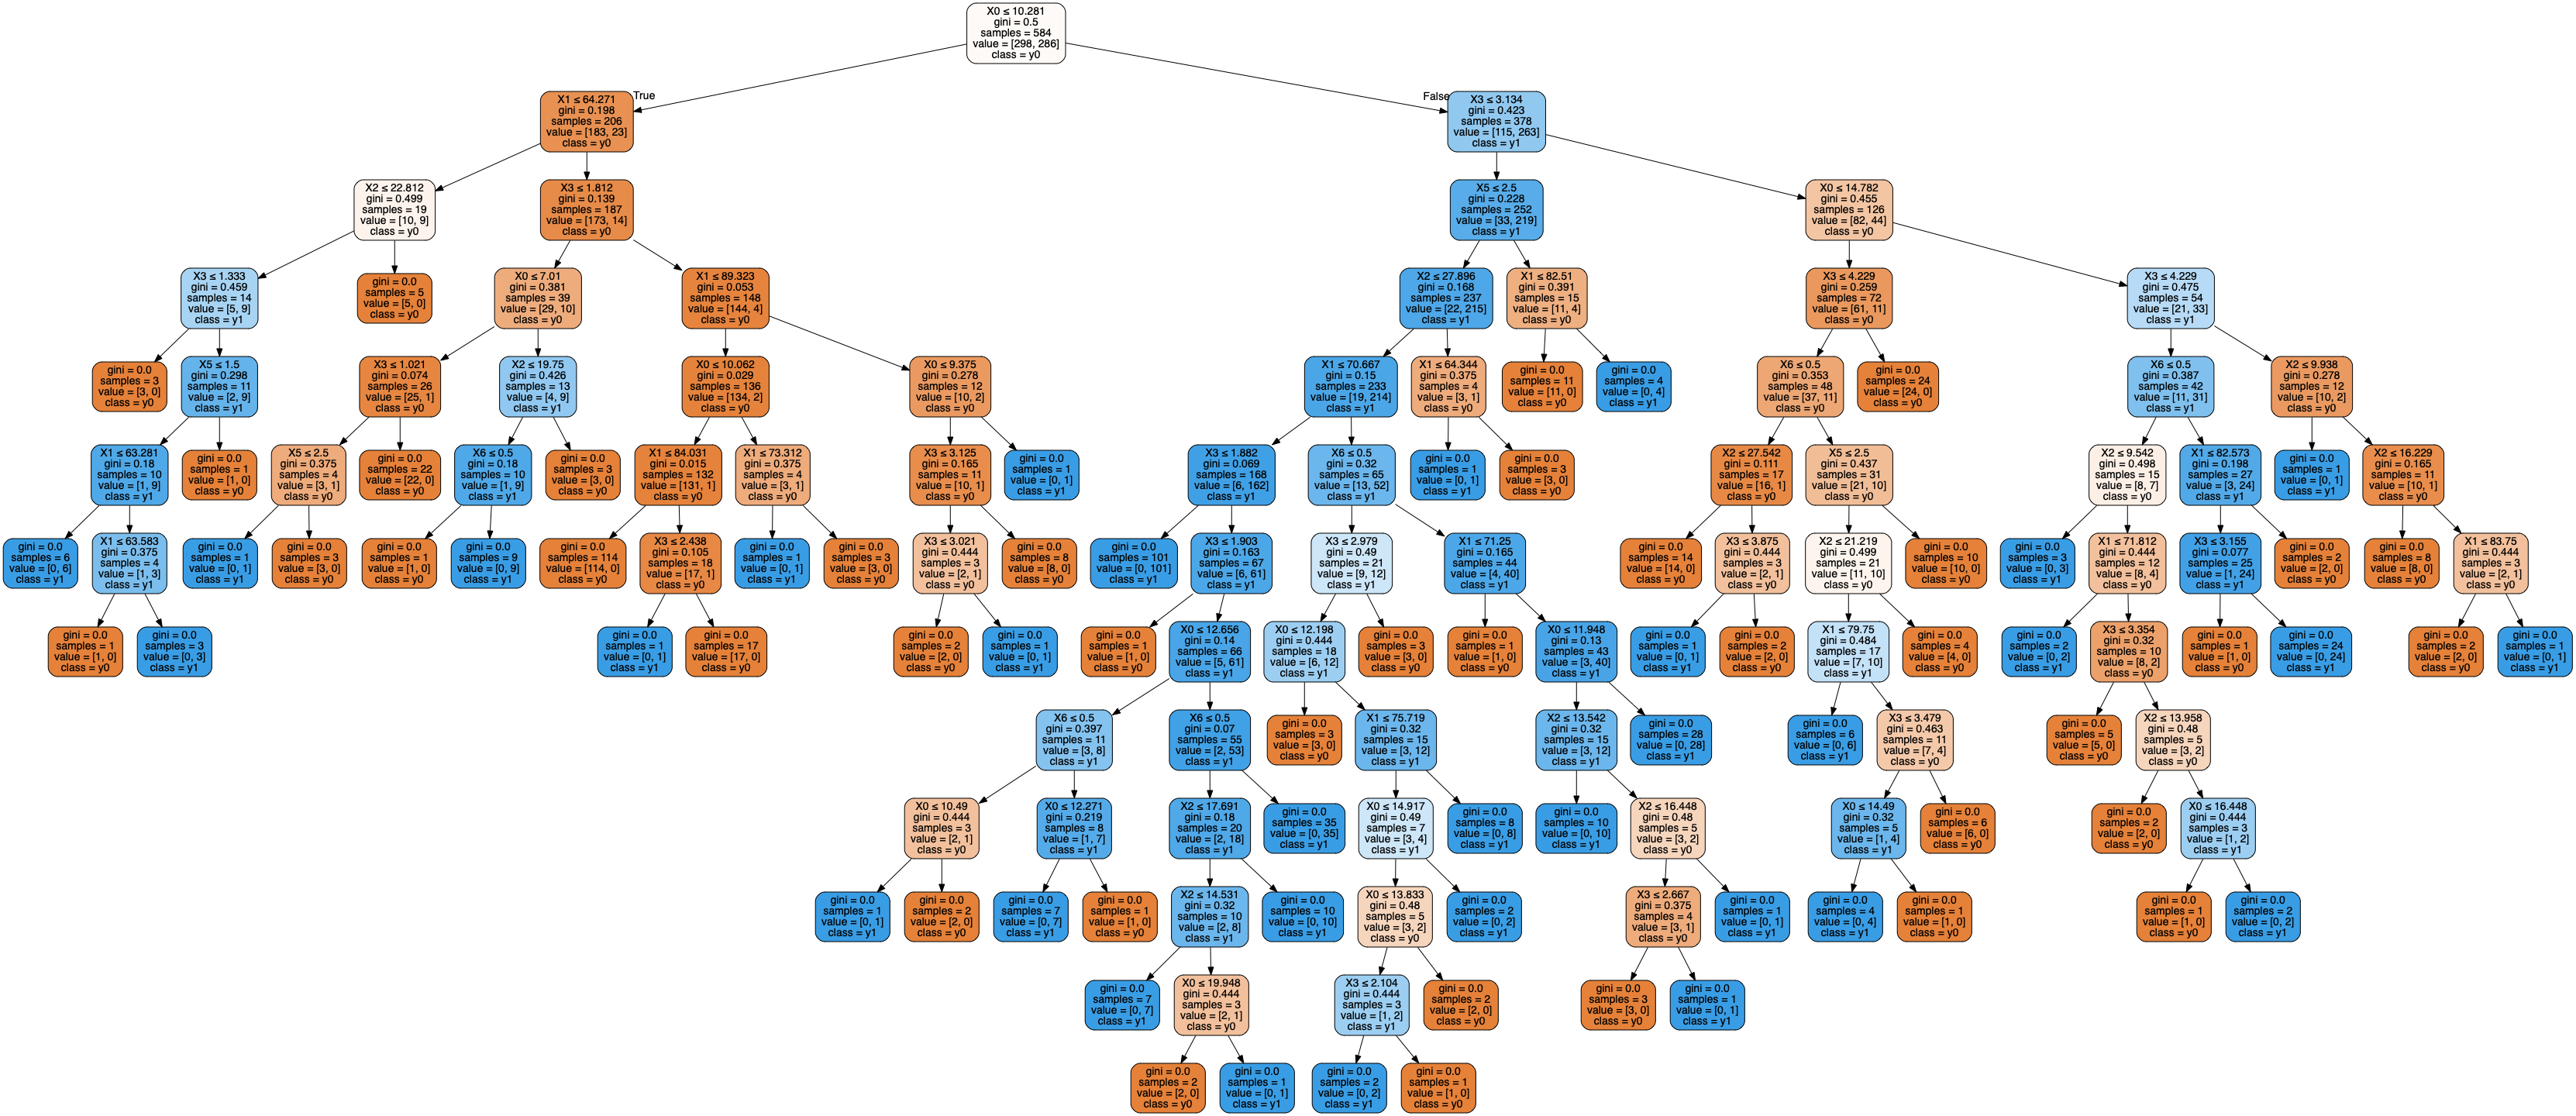

In [18]:
dot_data = StringIO()
export_graphviz(classifier,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                class_names=True
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [19]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])

feature_importances.sort_values(by='importance', ascending=False)

,importance
temp,0.437798
weather_code,0.269640
hum,0.110922
wind,0.081728
season,0.060367
is_workday,0.039544
is_holiday,0.000000


# GridSearch

In [24]:
g_params = {'max_depth':list(range(1, 11))+[None],'max_features':[None, 1, 2, 3],'max_leaf_nodes':[None,2,3,4],
             'min_samples_leaf':[2,3,4, 5, 10, 15, 20, 25, 30, 40, 50],'min_samples_split':[2,3]}




gridsearch = GridSearchCV(classifier , g_params ,return_train_score=True,  cv=10)
gridsearch.get_params().keys()
gridsearch.fit(X_train, y_train)

/Users/vilvaki/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'max_features': [None, 1, 2, 3], 'max_leaf_nodes': [None, 2, 3, 4], 'min_samples_leaf': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'min_samples_split': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
pd.DataFrame(gridsearch.cv_results_).head()
print(gridsearch.best_estimator_)
print('Score:', gridsearch.best_score_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
Score: 0.863013698630137


In [26]:
gridsearch.score(X_test, y_test)

0.8493150684931506

In [27]:
X_test

,temp,hum,wind,weather_code,is_holiday,season,is_workday
timestamp,,,,,,,
2016-02-19,6.208333,78.958333,19.541667,2.708333,0.0,3.0,1.0
2015-05-26,14.916667,60.062500,14.604167,1.541667,0.0,0.0,1.0
2016-10-25,11.833333,79.062500,5.187500,2.416667,0.0,2.0,1.0
2016-01-05,8.979167,85.666667,8.437500,3.041667,0.0,3.0,1.0
2015-03-21,7.625000,72.041667,16.479167,3.083333,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2016-09-19,18.104167,70.104167,7.333333,3.000000,0.0,2.0,1.0
2016-03-03,7.020833,67.645833,21.791667,2.916667,0.0,0.0,1.0
2016-06-03,11.291667,84.895833,12.270833,3.416667,0.0,1.0,1.0


In [29]:
london

NameError: name 'london' is not defined